In [504]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression



In [505]:
from sklearn.metrics import mean_squared_error as mse


In [506]:
from sklearn.model_selection import train_test_split as split

In [507]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import pairwise_distances

In [508]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [509]:
path = '/content/drive/MyDrive/Colab Notebooks/RegressionProject/'
df_laptops = pd.read_csv(path + 'laptops.csv',encoding='latin-1')
df_laptops.head()

,Unnamed: 0,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [510]:
df_laptops.shape

(1303, 13)

In [511]:
#drop the GB from Ram Column, and change it to numeric value
df_laptops.Ram = df_laptops.Ram.apply(lambda x: int(x.replace('GB','')))
df_laptops.rename(columns={'Ram':'Ram_GB'}, inplace=True)

In [512]:
#remove the 'KG' from Weight Column, and change to numeric
df_laptops.Weight = df_laptops.Weight.apply(lambda x: float(x.replace('kg','')))
df_laptops.rename(columns={'Weight':'Weight_kg'}, inplace=True)

In [513]:
std = df_laptops.Price_euros.std()
ave = df_laptops.Price_euros.mean()
df_laptops = df_laptops.loc[df_laptops['Price_euros'].between(ave-5*std, ave+5*std)]
df_laptops.shape


(1300, 13)

In [514]:
def filling_memory_size_cols(row):  
  x = ' '.join(re.findall("[0-9]+[A-Z]+ SSD", row)).replace('GB SSD' ,'').replace('1TB SSD' ,'1024')
  if len(x) == 0:
    x = 0
    return x    
  if ' ' in x:
    y = x.split()
    y[0] = int(y[0])
    y[1] = int(y[1])
    x = y[0] + y[1]
  else:
    x = int(x)   
  return x
 
   
df_laptops['Memory_SSD_size'] = df_laptops.Memory.apply(filling_memory_size_cols)
df_laptops['Memory_SSD_size'].value_counts()

256     498
0       460
128     172
512     137
1024     15
32        6
180       5
16        3
64        1
768       1
240       1
8         1
Name: Memory_SSD_size, dtype: int64

In [515]:
def filling_memory_size_cols(row,mtype):
  row = row.replace('.','')  
  x = ' '.join(re.findall("[0-9]+[A-Z]+ "+mtype, row)).replace('GB '+mtype ,'')\
                                                      .replace('1TB '+mtype ,'1024')\
                                                      .replace('10TB '+mtype ,'1024')\
                                                      .replace('2TB '+mtype ,'2048')
  if len(x) == 0:
    x = 0
    return x    
  if ' ' in x:
    y = x.split()
    y[0] = int(y[0])
    y[1] = int(y[1])
    x = y[0] + y[1]
  else:
    x = int(x)   
  return x


df_laptops['Memory_HDD_size'] = df_laptops.Memory.apply(filling_memory_size_cols,mtype='HDD')
df_laptops['Memory_HDD_size'].value_counts()
df_laptops['Memory_Flash_Storage_size'] = df_laptops.Memory.apply(filling_memory_size_cols,mtype='Flash Storage')
df_laptops['Memory_Flash_Storage_size'].value_counts()
df_laptops['Memory_Hybrid_size'] = df_laptops.Memory.apply(filling_memory_size_cols,mtype='Hybrid')
df_laptops['Memory_Hybrid_size'].value_counts()


0       1288
1024      11
508        1
Name: Memory_Hybrid_size, dtype: int64

In [516]:
df_laptops['cpu_producer'] = df_laptops['Cpu'].str.split(' ').str[0]
df_laptops['cpu_producer'].value_counts()

Intel      1237
AMD          62
Samsung       1
Name: cpu_producer, dtype: int64

In [517]:
df_laptops['cpu_model'] = df_laptops['Cpu'].apply(lambda x: ' '.join(x.split(' ')[1:-1]))
df_laptops['cpu_model'].value_counts()
#checking if GHz is snicking in the data series
df_laptops['cpu_model'].isin(['GHz']).any()

False

In [518]:
df_laptops['cpu_speed_GHz'] = df_laptops['Cpu'].str.split(' ').str[-1]
df_laptops['cpu_speed_GHz'] = df_laptops['cpu_speed_GHz'].str.replace('GHz','')
df_laptops['cpu_speed_GHz'] = df_laptops['cpu_speed_GHz'].astype(float)
df_laptops['cpu_speed_GHz'].value_counts()

2.50    293
2.70    166
2.80    165
1.60    134
2.30     86
2.00     86
1.80     78
2.60     76
1.10     53
2.40     52
2.90     19
3.00     19
1.20     15
1.44     12
2.20     11
1.50     10
1.30      6
3.60      5
0.90      4
2.10      3
1.90      2
3.10      2
3.20      1
1.00      1
1.92      1
Name: cpu_speed_GHz, dtype: int64

In [519]:
temp = df_laptops.ScreenResolution.str.split().str.get(-1)
# df_laptops['Reso'] = temp.str.get(-1)
df_laptops[['Screen_Width', 'Screen_Height']] = temp.str.split('x', expand=True)


df_laptops.Screen_Width.nunique()
df_laptops.Screen_Height.nunique()

10

In [520]:
df_laptops.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1302
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 1300 non-null   int64  
 1   Company                    1300 non-null   object 
 2   Product                    1300 non-null   object 
 3   TypeName                   1300 non-null   object 
 4   Inches                     1300 non-null   float64
 5   ScreenResolution           1300 non-null   object 
 6   Cpu                        1300 non-null   object 
 7   Ram_GB                     1300 non-null   int64  
 8   Memory                     1300 non-null   object 
 9   Gpu                        1300 non-null   object 
 10  OpSys                      1300 non-null   object 
 11  Weight_kg                  1300 non-null   float64
 12  Price_euros                1300 non-null   float64
 13  Memory_SSD_size            1300 non-null   int64

In [521]:
df_laptops.head()

,Unnamed: 0,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram_GB,Memory,Gpu,OpSys,Weight_kg,Price_euros,Memory_SSD_size,Memory_HDD_size,Memory_Flash_Storage_size,Memory_Hybrid_size,cpu_producer,cpu_model,cpu_speed_GHz,Screen_Width,Screen_Height
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,128,0,0,0,Intel,Core i5,2.3,2560,1600
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,898.94,0,0,128,0,Intel,Core i5,1.8,1440,900
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,575.00,256,0,0,0,Intel,Core i5 7200U,2.5,1920,1080
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,2537.45,512,0,0,0,Intel,Core i7,2.7,2880,1800
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,256,0,0,0,Intel,Core i5,3.1,2560,1600


In [522]:
df_laptops.drop(columns=['Unnamed: 0','ScreenResolution','Cpu','Ram_GB','Memory'],inplace=True)

In [523]:
# company_less_ten = dict(df_laptops.Company.value_counts()<10)
# df_laptops['Company'] = df_laptops.Company.apply(lambda x : 'Others' if company_less_ten[x] else x)


In [524]:
df_laptops.OpSys.value_counts()

Windows 10      1069
No OS             66
Linux             62
Windows 7         45
Chrome OS         27
macOS             13
Mac OS X           8
Windows 10 S       8
Android            2
Name: OpSys, dtype: int64

In [525]:
df_laptops.OpSys = df_laptops.OpSys.str.replace('Windows 10','Windows').replace('Windows 7','Windows').replace('Windows 10 S','Windows').replace('Windows S','Windows')
df_laptops = df_laptops[(df_laptops["OpSys"] != 'Android')]
df_laptops.OpSys = df_laptops.OpSys.str.replace('Mac OS X','macOS')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [526]:
df_laptops.OpSys.value_counts()

Windows      1122
No OS          66
Linux          62
Chrome OS      27
macOS          21
Name: OpSys, dtype: int64

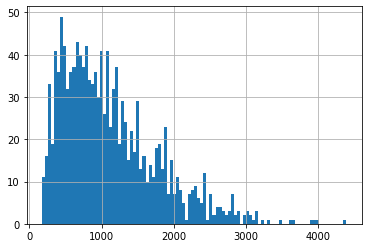

In [527]:
df_laptops.Price_euros.hist(bins=100)


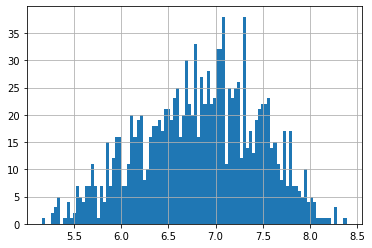

In [528]:
log_price = np.log1p(df_laptops.Price_euros)
log_price.hist(bins=100)
df_laptops.Price_euros = log_price

In [529]:
# X_train[['TypeName_Gaming', 'TypeName_Netbook','TypeName_Notebook', 'TypeName_Ultrabook', 'TypeName_Workstation']].sum()
# (X_train[['Memory_SSD_size', 'Memory_HDD_size','Memory_Flash_Storage_size', 'Memory_Hybrid_size']]>0).sum()
# X_train.columns
# (X_train[['cpu_producer_AMD', 'cpu_producer_Intel']]>0).sum()


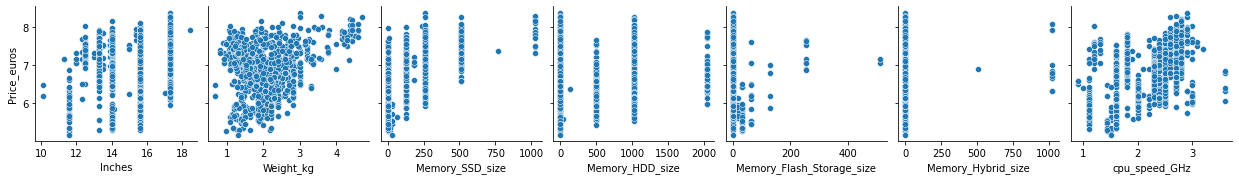

In [530]:
sns.pairplot(data=df_laptops, x_vars=['Inches','Weight_kg','Memory_SSD_size', 'Memory_HDD_size',
                'Memory_Flash_Storage_size', 'Memory_Hybrid_size','cpu_speed_GHz'], y_vars=['Price_euros'])

In [531]:
df_laptops.Company.value_counts()


Dell         297
Lenovo       294
HP           274
Asus         158
Acer         103
MSI           54
Toshiba       48
Apple         21
Samsung        9
Mediacom       7
Microsoft      6
Razer          5
Xiaomi         4
Vero           4
Chuwi          3
Google         3
Fujitsu        3
LG             3
Huawei         2
Name: Company, dtype: int64

In [532]:
df_pivot_laptops = df_laptops.pivot_table(values='Price_euros', index='Company', aggfunc="mean")

df_laptops['Company_convert_avg_price'] = df_laptops.Company.apply(lambda x: (df_pivot_laptops.loc[x,:]))
df_laptops['Company_convert_avg_price'].unique()

array([7.2997954 , 6.8148285 , 6.3154676 , 6.79965633, 6.9359724 ,
       6.79611989, 5.71186644, 7.40841503, 7.33014041, 7.07003685,
       7.26054013, 7.02131326, 5.38024906, 5.67345797, 7.1206024 ,
       7.4000464 , 6.58941143, 7.6858214 , 7.6466554 ])

In [533]:
df_laptops.TypeName.value_counts()

Notebook              726
Gaming                203
Ultrabook             196
2 in 1 Convertible    119
Workstation            29
Netbook                25
Name: TypeName, dtype: int64

In [534]:
df_pivot_laptops = df_laptops.pivot_table(values='Price_euros', index='TypeName', aggfunc="mean")

df_laptops['TypeName_convert_avg_price'] = df_laptops.TypeName.apply(lambda x: (df_pivot_laptops.loc[x,:]))
df_laptops['TypeName_convert_avg_price'].unique()

array([7.29367792, 6.52720972, 6.1178044 , 7.35303107, 7.04413009,
       7.69174555])

In [535]:
#remove outliers in cpu_producer
df_laptops = df_laptops[~(df_laptops.cpu_producer == 'Samsung')]

In [536]:
df_laptops['cpu_producer'].value_counts()

Intel    1235
AMD        62
Name: cpu_producer, dtype: int64

In [537]:
df_laptops['cpu_producer'] = df_laptops['cpu_producer'].replace({'AMD': 0, 'Intel': 1})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [538]:
# df_pivot_laptops = df_laptops.pivot_table(values='Price_euros', index='OpSys', aggfunc="mean")

# df_laptops['OpSys_convert_avg_price'] = df_laptops.OpSys.apply(lambda x: int(df_pivot_laptops.loc[x,:]))
# df_laptops['OpSys_convert_avg_price'].unique()

####The Models

###Linear Regression 

In [539]:
df_laptops0 = df_laptops[['Company','Weight_kg','Inches','OpSys','Memory_SSD_size', 'Memory_HDD_size', 
                          'Memory_Flash_Storage_size', 'Memory_Hybrid_size','cpu_producer','cpu_speed_GHz', 'TypeName', 'Price_euros']]
df_laptops0 = pd.get_dummies(df_laptops0, columns=['Company', 'OpSys', 'TypeName'])                         

In [540]:
# df_laptops0 = df_laptops[['Company_convert_avg_price','Weight_kg','Inches','OpSys','Memory_SSD_size', 'Memory_HDD_size', 
#                           'Memory_Flash_Storage_size', 'Memory_Hybrid_size','cpu_producer', 'TypeName_convert_avg_price','cpu_speed_GHz','Price_euros']]

# df_laptops0 = pd.get_dummies(df_laptops0, columns=[ 'OpSys'])                

In [541]:
X = df_laptops0.drop('Price_euros', axis=1)
y = df_laptops0['Price_euros']

In [542]:
# df_laptops0.columns

In [543]:
X_train, X_test, y_train, y_test = split(X, y, random_state=0)

In [544]:
math_lm = LinearRegression().fit(X_train, y_train)
y_train_pred = math_lm.predict(X_train)

In [545]:
rmse = np.sqrt(mse(np.expm1(y_train), np.expm1(y_train_pred)))
print(f"rms_train = {rmse:.2f}")

rms_train = 414.76


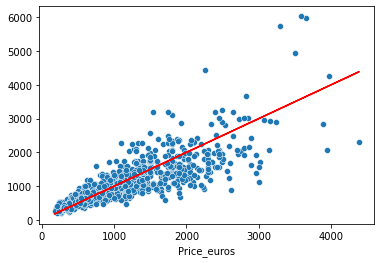

In [546]:
ax = sns.scatterplot(x=np.expm1(y_train), y=np.expm1(y_train_pred))
ax.plot(np.expm1(y_train), np.expm1(y_train), 'r')

In [547]:
list(zip(X_train.columns, math_lm.coef_))

[('Weight_kg', 0.1146180172560355),
 ('Inches', -0.025959957304915845),
 ('Memory_SSD_size', 0.0013955810969770003),
 ('Memory_HDD_size', 0.00010455711101063116),
 ('Memory_Flash_Storage_size', 0.0010262129535450473),
 ('Memory_Hybrid_size', 0.0001834681979043452),
 ('cpu_producer', 0.5124389530387778),
 ('cpu_speed_GHz', 0.3428104326151848),
 ('Company_Acer', -0.21045867246263505),
 ('Company_Apple', 0.20152067782534433),
 ('Company_Asus', -0.06729519518896002),
 ('Company_Chuwi', -0.3274340215115474),
 ('Company_Dell', 0.04090887542907055),
 ('Company_Fujitsu', -0.09799819267474852),
 ('Company_Google', 0.6802897591409331),
 ('Company_HP', 0.07150639299940433),
 ('Company_Huawei', -0.1587378729962298),
 ('Company_LG', 0.17095567921028315),
 ('Company_Lenovo', -0.03864460255514278),
 ('Company_MSI', 0.05573783905647556),
 ('Company_Mediacom', -0.5153351136373774),
 ('Company_Microsoft', 0.12093821527950677),
 ('Company_Razer', 0.14869620142838605),
 ('Company_Samsung', 0.1687974252056

In [548]:
y_test_pred = math_lm.predict(X_test)
rmse_test = mse(y_true=np.expm1(y_test), y_pred=np.expm1(y_test_pred), squared=False)
print('rms_test:', rmse_test)

rms_test: 361.0157442865881


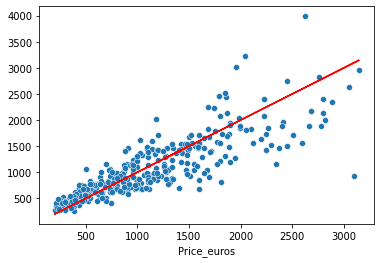

In [549]:
ax = sns.scatterplot(x=np.expm1(y_test), y=np.expm1(y_test_pred))
ax.plot(np.expm1(y_test), np.expm1(y_test), 'r')

### k-nearest neighbors

In [550]:
knn_model_1 = KNeighborsRegressor(n_neighbors=20, metric='euclidean')
knn_model_1.fit(X_train, y_train)

KNeighborsRegressor(metric='euclidean', n_neighbors=20)

In [551]:
y_train_pred = knn_model_1.predict(X_train)

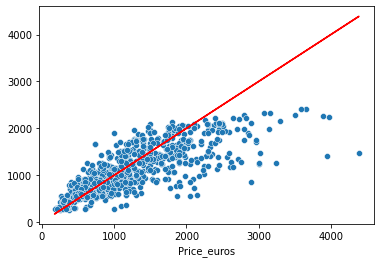

In [552]:
ax = sns.scatterplot(x=np.expm1(y_train), y=np.expm1(y_train_pred))
ax.plot(np.expm1(y_train), np.expm1(y_train), 'r')

In [553]:
RMSE = mse(np.expm1(y_train), np.expm1(y_train_pred), squared=False)
RMSE

415.7737171524867

In [554]:
y_test_pred = knn_model_1.predict(X_test)

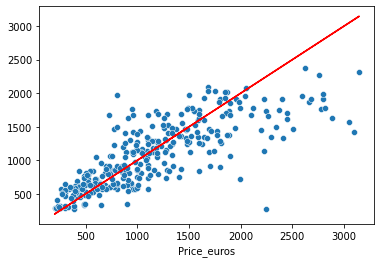

In [555]:
ax = sns.scatterplot(x=np.expm1(y_test), y=np.expm1(y_test_pred))
ax.plot(np.expm1(y_test), np.expm1(y_test), 'r')

In [556]:
RMSE = mse(np.expm1(y_test), np.expm1(y_test_pred), squared=False)
RMSE

393.48187458046374

In [557]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler

In [558]:
X_train.head()

,Weight_kg,Inches,Memory_SSD_size,Memory_HDD_size,Memory_Flash_Storage_size,Memory_Hybrid_size,cpu_producer,cpu_speed_GHz,Company_Acer,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,Company_Fujitsu,Company_Google,Company_HP,Company_Huawei,Company_LG,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Microsoft,Company_Razer,Company_Samsung,Company_Toshiba,Company_Vero,Company_Xiaomi,OpSys_Chrome OS,OpSys_Linux,OpSys_No OS,OpSys_Windows,OpSys_macOS,TypeName_2 in 1 Convertible,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Ultrabook,TypeName_Workstation
254,3.00,17.3,256,0,0,0,1,2.7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
783,2.20,15.6,0,1024,0,0,1,1.6,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
313,2.23,15.6,256,0,0,0,0,2.2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
798,1.38,13.9,256,0,0,0,1,2.7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
114,1.21,13.3,256,0,0,0,1,1.6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [559]:
my_scaler = MaxAbsScaler().fit(X_train)
X_train_scaled = pd.DataFrame(my_scaler.transform(X_train), columns=X_train.columns)
X_train_scaled.head()

,Weight_kg,Inches,Memory_SSD_size,Memory_HDD_size,Memory_Flash_Storage_size,Memory_Hybrid_size,cpu_producer,cpu_speed_GHz,Company_Acer,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,Company_Fujitsu,Company_Google,Company_HP,Company_Huawei,Company_LG,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Microsoft,Company_Razer,Company_Samsung,Company_Toshiba,Company_Vero,Company_Xiaomi,OpSys_Chrome OS,OpSys_Linux,OpSys_No OS,OpSys_Windows,OpSys_macOS,TypeName_2 in 1 Convertible,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Ultrabook,TypeName_Workstation
0,0.638298,0.940217,0.25,0.0,0.0,0.0,1.0,0.750000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.468085,0.847826,0.00,0.5,0.0,0.0,1.0,0.444444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.474468,0.847826,0.25,0.0,0.0,0.0,0.0,0.611111,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.293617,0.755435,0.25,0.0,0.0,0.0,1.0,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.257447,0.722826,0.25,0.0,0.0,0.0,1.0,0.444444,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [560]:
knn_model_2 = KNeighborsRegressor(n_neighbors=20).fit(X_train_scaled, y_train)

In [561]:
y_train_pred = knn_model_2.predict(X_train_scaled)

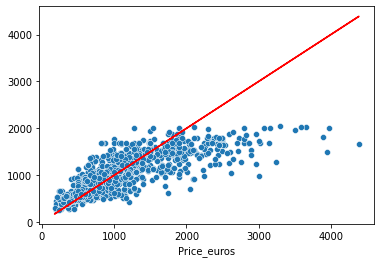

In [562]:
ax = sns.scatterplot(x=np.expm1(y_train), y=np.expm1(y_train_pred))
ax.plot(np.expm1(y_train), np.expm1(y_train), 'r')

In [563]:

RMSE = mse(np.expm1(y_train), np.expm1(y_train_pred), squared=False)
RMSE

433.9516250836231

In [564]:
X_test_scaled = my_scaler.transform(X_test)

In [565]:
y_test_pred = knn_model_2.predict(X_test_scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  "X does not have valid feature names, but"


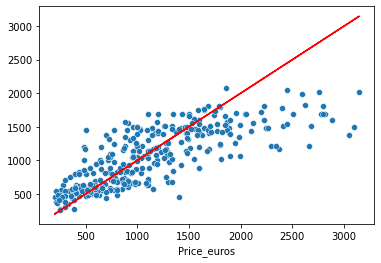

In [566]:
ax = sns.scatterplot(x=np.expm1(y_test), y=np.expm1(y_test_pred))
ax.plot(np.expm1(y_test), np.expm1(y_test), 'r')

In [567]:
RMSE = mse(np.expm1(y_test), np.expm1(y_test_pred))**0.5
RMSE

411.52287994929003